In [4]:
#from theano.sandbox import cuda

In [1]:
%matplotlib inline
from __future__ import division, print_function

In [2]:
import math, os
import numpy as np

In [3]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Activation, Reshape, Permute, merge
from keras.models import Sequential, Model
from keras.layers.merge import Concatenate
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.convolutional import *
from keras.layers.pooling import MaxPooling1D
from keras.utils.np_utils import to_categorical

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 3007.)


In [193]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## Load Reuters dataset

In [5]:
model_path = '../data/colearn/models/'

In [186]:
from keras.datasets import reuters
idx = reuters.get_word_index()

In [7]:
idx_arr = sorted(idx, key=idx.get)
idx_arr[:10]

[u'the', u'of', u'to', u'in', u'said', u'and', u'a', u'mln', u'3', u'for']

In [8]:
len(idx_arr)

30979

In [9]:
idx2word = {v: k for k, v in idx.iteritems()}

In [10]:
n = 5
(idx2word[n], idx[idx2word[n]])

(u'said', 5)

In [11]:
from keras.datasets import reuters

# WARNING : this function has a bug when oov_char is None
# source : https://raw.githubusercontent.com/fchollet/keras/master/keras/datasets/reuters.py
(x_train, labels_train), (x_test, labels_test) = reuters.load_data(path="reuters.npz",
                                                         num_words=None,
                                                         skip_top=0,
                                                         maxlen=None,
                                                         test_split=0.2,
                                                         seed=113,
                                                         start_char=None,
                                                         oov_char=0,
                                                         index_from=0)

### Total sample size

In [12]:
len(labels_train)+len(labels_test)

11228

In [13]:
L = []
L.extend(labels_train)
L.extend(labels_test)
nb_categories = len(set(L))

In [14]:
# x_train contains lists of variable length were words are represented by indices
len(x_train[0]), len(x_train[1]), len(x_train[2])

(86, 55, 138)

In [15]:
wrds = [idx2word[n] for n in x_train[3]]
' '.join(wrds)

u"the farmers home administration the u s agriculture department's farm lending arm could lose about seven billion dlrs in outstanding principal on its severely delinquent borrowers or about one fourth of its farm loan portfolio the general accounting office gao said in remarks prepared for delivery to the senate agriculture committee brian crowley senior associate director of gao also said that a preliminary analysis of proposed changes in fmha's financial eligibility standards indicated as many as one half of fmha borrowers who received new loans from the agency in 1986 would be ineligible under the proposed system the agency has proposed evaluating applicants' credit using a variety of financial ratios instead of relying solely on cashflow ability senate agriculture committee chairman patrick leahy d vt slammed the proposed eligibility changes telling fmha administrator vance clark at a hearing that they would mark a dramatic shift in the agency's purpose away from being farmers' le

In [16]:
vocab_size = 2500 # ignore rare words (i.e. ranked above this limit by decreasing occurence order)
maxlen = 500

In [17]:
def paddedset(orig_set):
    adj_set = [[min(n,vocab_size-1) for n in sq] for sq in orig_set]
    return pad_sequences(adj_set, maxlen=maxlen, dtype='int32', padding='pre', truncating='post', value=0)

In [18]:
x_train_pad = paddedset(x_train)
x_test_pad = paddedset(x_test)

In [19]:
print(len(x_train[0]))
print(x_train[0][0:8])
print([n for n in x_train_pad[0] if n>0][0:8])

86
[27592, 28839, 5, 40, 7, 444, 2, 22]
[2499, 2499, 5, 40, 7, 444, 2, 22]


## Turn Reuters dataset into CBOW n-grams
### Remember that CBOW is an unsupervised semantic model

In [20]:
cbow_lag = 2 # (lag, _, lag) => t

def f(inputs=x_train, size=1000):
    outputs = []
    for sentence in x_train[0:size]:
        for i in range(cbow_lag, len(sentence)-cbow_lag):
            outputs.append( (sentence[i-cbow_lag:i] + sentence[i+1:i+cbow_lag+1], sentence[i]) )
    return outputs

In [21]:
cbow_train = f(x_train, size=5000)
len(cbow_train)

709702

In [22]:
cbow_test = f(x_test, size=2000)
len(cbow_test)

289222

In [23]:
np.random.shuffle(cbow_train)
cbow_x_train = [x for x, y in cbow_train if max(x)<vocab_size and y<vocab_size]
cbow_labels_train = [y for x, y in cbow_train if max(x)<vocab_size and y<vocab_size]
print(len(cbow_x_train))

np.random.shuffle(cbow_test)
cbow_x_test = [x for x, y in cbow_test if max(x)<vocab_size and y<vocab_size]
cbow_labels_test = [y for x, y in cbow_test if max(x)<vocab_size and y<vocab_size]

391752


## Load GloVe embedding pre-trained weights
#### Command to use :
wget http://nlp.stanford.edu/data/glove.6B.zip

In [24]:
GLOVE_DIR = '../data/glove6B/'
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [25]:
k = embeddings_index.keys()[0]
v = embeddings_index[k]
print(k, v.shape)

biennials (100,)


In [26]:
newwords = embeddings_index.keys()
count = 0
for i in range(1,vocab_size):
    if not(idx2word[i] in newwords):
        count+=1
        #print(idx2word[i])
count

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


41

In [27]:
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
#for word, i in idx2word[i]:#word_index.items():
for i in range(1,vocab_size):
    word = idx2word[i]
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [28]:
pretrained = True # use Glove weights or not

In [29]:
# Turning words into embedded vectors
#    Documentation : https://keras.io/layers/embeddings/
#    The model will take as Input an integer matrix of size (batch_size, n_words).
#    The largest integer (i.e. word index) in the input should be no larger than vocab_size.
#    Now model.output_shape == (None, n_words, n_embed), where None is the batch dimension.
if pretrained:
    EMBEDDING = Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix]) # WARNING : input_length ?
else:
    EMBEDDING = Embedding(vocab_size, EMBEDDING_DIM) # WARNING : input_length ?

### CBOW model to infer semantics

In [30]:
n_words = 2*cbow_lag # we use LAG words before and LAG words after as inputs
batch_size = 100

In [31]:
modelWRD = Sequential()

# First layer is a dummy-permutation = Identity to specify input shape
modelWRD.add( Permute((1,), input_shape=(n_words,)) ) # WARNING : axis 0 is the sample dim

modelWRD.add(EMBEDDING)

modelWRD.add(Lambda(lambda x : K.sum(x,axis=1), output_shape=(EMBEDDING_DIM,)))

modelWRD.add(Dense(vocab_size, input_shape=(EMBEDDING_DIM,), activation='softmax'))

In [32]:
modelWRD.predict(np.ones((5,n_words))).shape

(5, 2500)

In [39]:
modelWRD.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 4)                 0         
_________________________________________________________________
embedding_1 (Embedding)      multiple                  250000    
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2500)              252500    
Total params: 502,500
Trainable params: 252,500
Non-trainable params: 250,000
_________________________________________________________________


#### First round of training : keeps embedding matrix fixed

In [40]:
EMBEDDING.trainable = False # WARNING : needs re-compiling to be effective
modelWRD.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
modelWRD.fit(cbow_x_train, to_categorical(cbow_labels_train,vocab_size),
             batch_size=64,
             epochs=3,
             shuffle=True)

Epoch 1/3
391752/391752 [==============================] - 32s - loss: 5.1634 - acc: 0.1478    
Epoch 2/3
391752/391752 [==============================] - 32s - loss: 4.7221 - acc: 0.1750    
Epoch 3/3
391752/391752 [==============================] - 32s - loss: 4.6079 - acc: 0.1825    


#### Second round of training : tune the embedding matrix too

In [42]:
EMBEDDING.trainable = True # WARNING : needs re-compiling to be effective
modelWRD.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
#modelWRD.optimizer.lr = 1e-4
modelWRD.fit(cbow_x_train, to_categorical(cbow_labels_train,vocab_size),
             batch_size=64,
             epochs=3,
             shuffle=True)

Epoch 1/3
391752/391752 [==============================] - 36s - loss: 4.2466 - acc: 0.2362    
Epoch 2/3
391752/391752 [==============================] - 36s - loss: 3.8919 - acc: 0.2759    
Epoch 3/3
391752/391752 [==============================] - 36s - loss: 3.7200 - acc: 0.2936    


### Prediction model of text category

In [44]:
EMBEDDING.trainable = False

In [45]:
# Neural Network architecture defined here :
#     https://quid.com/feed/how-quid-uses-deep-learning-with-small-data
graph_in = Input(shape=(maxlen, EMBEDDING_DIM))

convs = []
for w in range(1,4): # the convolution window width
    conv = Conv1D(filters=300,
                  kernel_size=w,
                  padding='valid',
                  activation='relu',
                  strides=1)(graph_in)
    pool = MaxPooling1D(pool_size=2)(conv) # WARNING : this line caused error when updating to Keras 2
    flatten = Flatten()(pool)
    convs.append(flatten)

out = Concatenate(axis=-1)(convs) # WARNING : check axis and dimension
graph = Model(inputs=graph_in, outputs=out)

In [46]:
modelTXT = Sequential()

# First layer is a dummy-permutation = Identity to specify input shape
modelTXT.add( Permute((1,), input_shape=(maxlen,)) ) # WARNING : axis 0 is the sample dim

if True:
    modelTXT.add(EMBEDDING)
else:
    # INFO : may not be necessary but cleared this way, otherwise shape in .summary is not clear
    EMBEDDING_TXT = Embedding(vocab_size, EMBEDDING_DIM, weights=EMBEDDING.get_weights())
    EMBEDDING_TXT.trainable = False
    modelTXT.add(EMBEDDING_TXT)

modelTXT.add(graph)

modelTXT.add(Dense(300))
modelTXT.add(Dropout(0.5))
modelTXT.add(Activation('relu'))
modelTXT.add(Dense(100))
modelTXT.add(Dropout(0.5))
modelTXT.add(Activation('relu'))
modelTXT.add(Dense(nb_categories))
modelTXT.add(Activation('softmax'))

In [47]:
modelTXT.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_3 (Permute)          (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      multiple                  250000    
_________________________________________________________________
model_2 (Model)              (None, 224400)            180900    
_________________________________________________________________
dense_5 (Dense)              (None, 300)               67320300  
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
activation_4 (Activation)    (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               30100     
__________

In [48]:
modelTXT.compile(optimizer=Adam(), loss='categorical_crossentropy',metrics=['accuracy'])

In [54]:
# WARNING : should run this for at east 5 epochs
modelTXT.fit(x_train_pad,
             to_categorical(labels_train, nb_categories),
             batch_size=100,
             validation_data=(x_test_pad, to_categorical(labels_test, nb_categories)),
             epochs=1)

Train on 8982 samples, validate on 2246 samples
Epoch 1/1
8982/8982 [==============================] - 134s - loss: 1.0941 - acc: 0.7296 - val_loss: 1.3053 - val_acc: 0.7012


In [52]:
modelTXT.predict(x_test_pad[0:5]).shape

(5, 46)

In [190]:
labels_test[10:25]

array([ 5,  4,  1,  3,  1, 11, 23,  3, 19,  3,  8,  3,  3,  3,  9])

In [189]:
np.argmax(modelTXT.predict(x_test_pad[10:25]), axis=1)

array([ 1,  4,  1,  3,  1, 11,  4,  3, 19,  3,  8,  3,  3,  4,  1])

In [192]:
wrds = [idx2word[n] for n in x_test[10]]
' '.join(wrds)

u"grain traders said they were still awaiting results of yesterday's u k intervention feed wheat tender for the home market the market sought to buy 340 000 tonnes more than double the remaining 150 000 tonnes available under the current tender however some of the tonnage included duplicate bids for supplies in the same stores since the tenders started last july 861 000 tonnes of british feed wheat have been sold back to the home market reuter 3"

In [115]:
cls_true = labels_test
cls_pred = np.argmax(modelTXT.predict(x_test_pad), axis=1)

In [155]:
cm = confusion_matrix(cls_true, cls_pred, labels=range(nb_categories))

In [159]:
# diagonal 25 first categories
cm[range(nb_categories),range(nb_categories)][0:25]

array([  0,  90,   0, 778, 415,   0,   0,   0,  11,   0,   0,  59,   0,
         4,   0,   0,  78,   0,   6,  91,  32,  11,   0,   0,   0])

In [160]:
# remove rare categories
cm = cm[0:25,0:25]

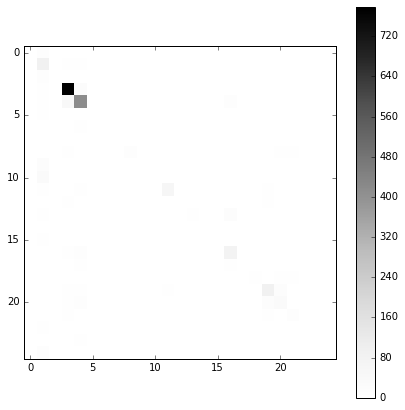

In [162]:
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greys)
plt.colorbar()

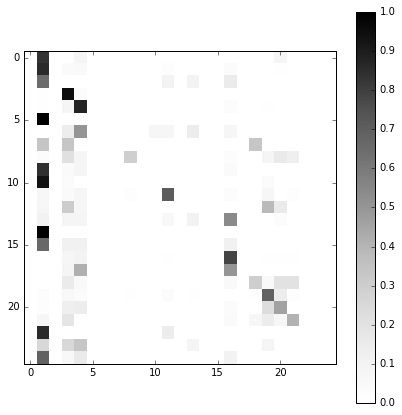

In [166]:
plt.figure(figsize=(7,7))
plt.imshow(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],
           interpolation='nearest',
           cmap=plt.cm.Greys)
plt.colorbar()